In [1]:
import pandas as pd
import numpy as np
from array import array

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim.downloader as api
import nltk

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelBinarizer

from keras.layers import Bidirectional

from keras.callbacks import EarlyStopping

from nltk.corpus import stopwords

### Load Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sst2")

Found cached dataset parquet (C:/Users/umar/.cache/huggingface/datasets/stanfordnlp___parquet/stanfordnlp--sst2-c614fb49d6bf6d65/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [4]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['validation'])

### Remove Duplicates 

In [5]:
train_df = train_df.drop_duplicates(subset='sentence')

### Pre-Processing

#### - Vectorizing (word2vec-google-news-300)
#### - removing stopwords

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

def vectorize(sentences, model_type='word2vec-google-news-300', wv_type='zero_padding'):
    tokens = [nltk.word_tokenize(s.lower()) for s in sentences]
    try:
        model = api.load(model_type)
        dimension = int(model_type.split('-')[-1])
    except Exception as e:
        logging.warning(f"An error occurred: {e}")
        exit(1)
    wvs = []
    for t in tokens:
        wv = []
        for w in t:
            if wv_type == 'zero_padding':
                try:
                    wv.append(model[w])
                except KeyError:
                    wv.append(np.zeros(dimension))
        wvs.append(wv)
    return wvs

In [8]:
train_df_noStopWords = train_df.copy()
test_df_noStopWords = test_df.copy()

In [9]:
train_df_noStopWords['sentence'] = train_df['sentence'].apply(remove_stopwords)
test_df_noStopWords['sentence'] = test_df['sentence'].apply(remove_stopwords)

In [10]:
train_feature = train_df['sentence'].values
test_feature = test_df['sentence'].values

train_ns_feature = train_df_noStopWords['sentence'].values
test_ns_feature = test_df_noStopWords['sentence'].values

In [11]:
train = vectorize(train_feature)
test = vectorize(test_feature)

train_ns = vectorize(train_ns_feature)
test_ns = vectorize(test_ns_feature)

In [12]:
train_labels = train_df['label']
test_labels = test_df['label']

In [13]:
train_y = train_labels.values
test_y = test_labels.values

#### Padding

In [14]:
sequence_lengths_train = [len(seq) for seq in train]
max_length_train = max(sequence_lengths_train)

sequence_lengths_test = [len(seq) for seq in test]
max_length_test = max(sequence_lengths_test)

sequence_lengths_train_ns = [len(seq) for seq in train_ns]
max_length_train_ns = max(sequence_lengths_train_ns)

sequence_lengths_test_ns = [len(seq) for seq in test_ns]
max_length_test_ns = max(sequence_lengths_test_ns)

In [15]:
padded_train = [seq + [[0.0] * len(train[0][0])] * (max_length_train - len(seq)) for seq in train]
padded_test = [seq + [[0.0] * len(test[0][0])] * (max_length_test - len(seq)) for seq in test]

padded_train_ns = [seq + [[0.0] * len(train_ns[0][0])] * (max_length_train_ns - len(seq)) for seq in train_ns]
padded_test_ns = [seq + [[0.0] * len(test_ns[0][0])] * (max_length_test_ns - len(seq)) for seq in test_ns]

In [16]:
X_train = np.array(padded_train)
X_test = np.array(padded_test)

X_train_ns = np.array(padded_train_ns) # no stop words
X_test_ns = np.array(padded_test_ns)

y_train = np.array(train_y)
y_test = np.array(test_y)

### Model training for data with stopwords

In [17]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Define input layer
input_layer = Input(shape=input_shape)

# Define the LSTM model with multiple layers
model3 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    LSTM(64, return_sequences=True),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')  # Change activation to sigmoid
])

C:\Users\umar\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Change loss to binary_crossentropy
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model with validation data
history = model3.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 52s 114ms/step - accuracy: 0.7972 - loss: 0.4163 - val_accuracy: 0.8446 - val_loss: 0.3411
Epoch 2/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.8683 - loss: 0.3015 - val_accuracy: 0.8773 - val_loss: 0.2873
Epoch 3/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.8886 - loss: 0.2591 - val_accuracy: 0.8896 - val_loss: 0.2592
Epoch 4/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.9118 - loss: 0.2155 - val_accuracy: 0.9019 - val_loss: 0.2391
Epoch 5/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.9225 - loss: 0.1908 - val_accuracy: 0.9133 - val_loss: 0.2227
Epoch 6/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.9353 - loss: 0.1617 - val_accuracy: 0.9097 - val_loss: 0.2268
Epoch 7/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - accuracy: 0.9446 - loss: 0.1415 - val_accuracy: 0.9168 - val_loss: 0.2197
Epoch 8/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 47s 113ms/step - accuracy: 0.9518 - loss: 0

### Model training for data with no stopwords

In [19]:
# Define input shape
input_shape = (X_train_ns.shape[1], X_train_ns.shape[2])

# Define input layer
input_layer = Input(shape=input_shape)

# Define the LSTM model with multiple layers
model4 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    LSTM(64, return_sequences=True),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')  # Change activation to sigmoid
])

In [20]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Change loss to binary_crossentropy
history2 = model4.fit(X_train_ns, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.7912 - loss: 0.4367 - val_accuracy: 0.8458 - val_loss: 0.3483
Epoch 2/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.8608 - loss: 0.3181 - val_accuracy: 0.8630 - val_loss: 0.3118
Epoch 3/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.8802 - loss: 0.2844 - val_accuracy: 0.8713 - val_loss: 0.2985


### Loss and accuracy plot for model trained with data with stop words

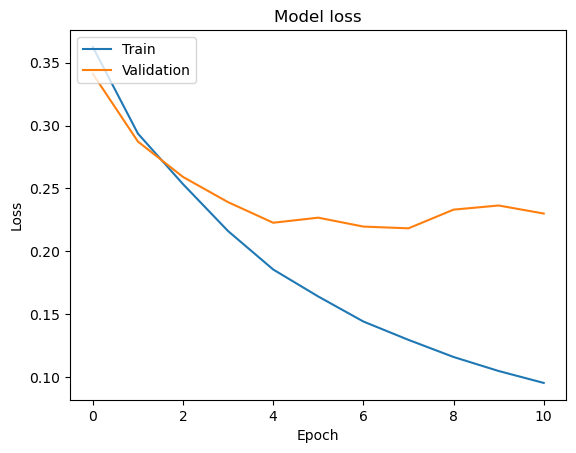

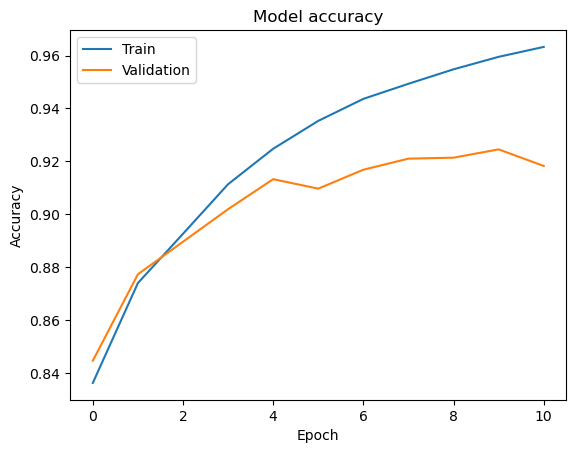

In [21]:
import matplotlib.pyplot as plt

# Assuming 'history' contains training history returned by model.fit()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Loss and accuracy plot for model trained with data with no stop words

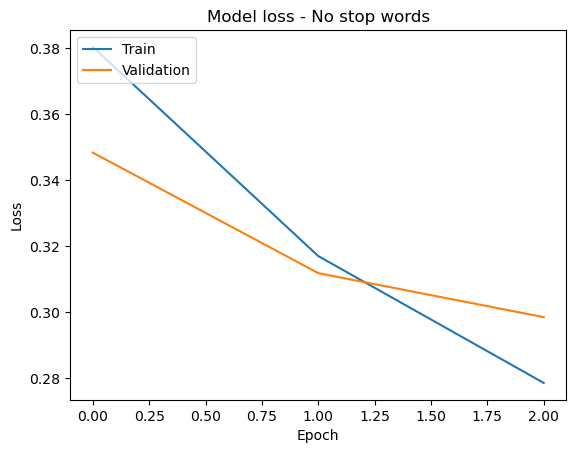

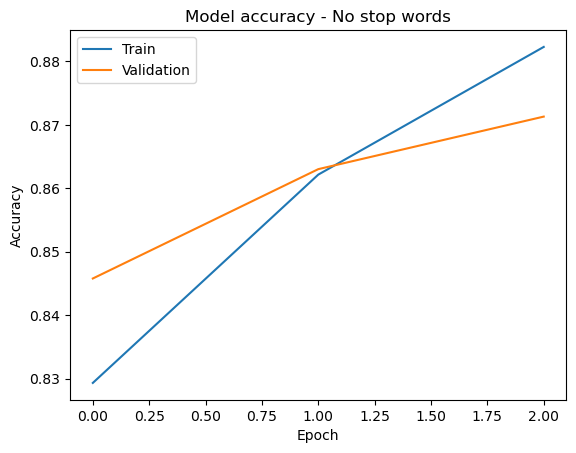

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' contains training history returned by model.fit()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss - No stop words')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy - No stop words')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Accuracy for test set -- data with stop words

In [23]:
test_loss, test_accuracy = model3.evaluate(X_test, y_test)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8503 - loss: 0.4619
Test Loss: 0.5019938349723816
Test Accuracy: 0.8451834917068481


### Accuracy for test set -- data with no stop words

In [24]:
test_loss, test_accuracy = model4.evaluate(X_test, y_test)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7803 - loss: 0.4683
Test Loss: 0.4623233377933502
Test Accuracy: 0.7786697149276733


### Result from SST2 dataset::

### Data with stop words seem give the model a higher accuracy than the one without stop words.

## Testing model with the IMDB Dataset

In [25]:
IMDB_test = pd.read_csv('IMDB Dataset.csv')

In [26]:
IMDB_test

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Preprocessing -- Vectorizing and padding (similar to the sst2 dataset)

In [27]:
IMDB_test_sample = IMDB_test.sample(n=10000, random_state=42)

In [28]:
IMDB_test_sample['sentiment'] = IMDB_test_sample['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [29]:
IMDB_test_feature = IMDB_test_sample['review'].values
IMDB_test_label = IMDB_test_sample['sentiment'].values

In [30]:
IMDB_test = vectorize(IMDB_test_feature)

In [31]:
IMDB_sequence_lengths_test = [len(seq) for seq in IMDB_test]
IMDB_max_length_test = max(IMDB_sequence_lengths_test)

In [32]:
IMDB_padded_test = [seq + [[0.0] * len(IMDB_test[0][0])] * (IMDB_max_length_test - len(seq)) for seq in IMDB_test]

In [33]:
X_IMDB_test = np.array(IMDB_padded_test)
y_IMDB_test = np.array(IMDB_test_label)

### Testing the model trained with sst2 (with stop words)

In [34]:
test_loss, test_accuracy = model3.evaluate(X_IMDB_test, y_IMDB_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 185s 590ms/step - accuracy: 0.7395 - loss: 0.8630
Test Loss: 0.8497645258903503
Test Accuracy: 0.7426000237464905


### Testing the model trained with sst2 (without stop words)

In [35]:
test_loss, test_accuracy = model4.evaluate(X_IMDB_test, y_IMDB_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 186s 592ms/step - accuracy: 0.6446 - loss: 0.6430
Test Loss: 0.6424870491027832
Test Accuracy: 0.6463000178337097


### Result from testing with IMDB dataset ::

### Model trained with data that has stopwords seem to have a higher accuracy compared to the data trained without stopwords